In [1]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [96]:
data = pd.read_csv('/Users/kalyani/Desktop/University/BMET2925/DATA2925/Data/frmgham2.csv')
data.columns

Index(['RANDID', 'SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE',
       'CIGPDAY', 'BMI', 'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ',
       'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD',
       'HDLC', 'LDLC', 'DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD',
       'STROKE', 'CVD', 'HYPERTEN', 'TIMEAP', 'TIMEMI', 'TIMEMIFC', 'TIMECHD',
       'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP'],
      dtype='object')

In [97]:
bpmeds_missing = data[data['BPMEDS'].isna()].index
# Filling the BPMeds missing values as according to above
for indx in bpmeds_missing:
  # For diabetic patients
  if data.loc[indx, 'DIABETES'] == 1 and (data.loc[indx, 'SYSBP'] > 130 or data.loc[indx, 'DIABP'] > 80):
    data.loc[indx, 'BPMEDS'] = 1
  
  # For non-diabetic patients
  elif data.loc[indx, 'DIABETES'] == 0 and (data.loc[indx, 'SYSBP'] > 140 or data.loc[indx, 'DIABP'] > 90):
    data.loc[indx, 'BPMEDS'] = 1
  
  # For rest of the patients
  else:
    data.loc[indx, 'BPMEDS'] = 0

# Imputing with median of current smokers
imputing_median1 = data[data['CURSMOKE'] == 'YES']['CIGPDAY'].median()
data['CIGPDAY'] = data['CIGPDAY'].fillna(imputing_median1)

# Imputing the missing values with the median for each variable
for var in ['TOTCHOL', 'BMI', 'HEARTRTE']:
  imputing_median = data[var].median()
  data[var]  = data[var].fillna(imputing_median)

# Initialize the IterativeImputer
imputer = IterativeImputer(random_state=0)

# Define the columns with missing values for imputation
columns_with_missing = ['CIGPDAY', 'GLUCOSE', 'educ', 'HDLC', 'LDLC']

# Fit the imputer to the data and impute missing values
imputer.fit(data[columns_with_missing])
data_imputed = data.dropna(subset=['CIGPDAY', 'educ']).copy()  # Create a copy of the cleaned data
data_imputed[columns_with_missing] = imputer.transform(data_imputed[columns_with_missing])

# Check for any remaining missing values in the imputed dataset
print("Remaining missing values after imputation:")
print(data_imputed.isna().sum())

Remaining missing values after imputation:
RANDID      0
SEX         0
TOTCHOL     0
AGE         0
SYSBP       0
DIABP       0
CURSMOKE    0
CIGPDAY     0
BMI         0
DIABETES    0
BPMEDS      0
HEARTRTE    0
GLUCOSE     0
educ        0
PREVCHD     0
PREVAP      0
PREVMI      0
PREVSTRK    0
PREVHYP     0
TIME        0
PERIOD      0
HDLC        0
LDLC        0
DEATH       0
ANGINA      0
HOSPMI      0
MI_FCHD     0
ANYCHD      0
STROKE      0
CVD         0
HYPERTEN    0
TIMEAP      0
TIMEMI      0
TIMEMIFC    0
TIMECHD     0
TIMESTRK    0
TIMECVD     0
TIMEDTH     0
TIMEHYP     0
dtype: int64


In [121]:
import numpy as np
import pandas as pd

# Compute the correlation matrix
correlation_matrix = data_imputed.corr().abs()

# Set a threshold for collinearity
threshold = 0.6  # Adjust as needed

# Find pairs of highly correlated features
correlated_pairs = np.where(correlation_matrix > threshold)

# Remove one feature from each highly correlated pair
features_to_drop = set()
for i, j in zip(*correlated_pairs):
    if i != j and i not in features_to_drop and j not in features_to_drop:
        # Choose one feature to drop based on some criterion (e.g., correlation with target variable)
        # For simplicity, you can drop the feature with the lower index
        features_to_drop.add(j)

# Drop highly correlated features from the dataset
data_filtered = data_imputed.drop(columns=data_imputed.columns[list(features_to_drop)])

# Proceed with feature selection using the filtered dataset

data_filtered.columns

Index(['RANDID', 'SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'CURSMOKE', 'BMI',
       'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ', 'PREVCHD',
       'PREVSTRK', 'TIME', 'HDLC', 'LDLC', 'DEATH', 'ANGINA', 'HOSPMI',
       'STROKE', 'CVD', 'HYPERTEN'],
      dtype='object')

In [126]:
# Get the columns present in data_filtered
columns_to_keep = data_filtered.columns

# Get the columns present in data but not in data_filtered
columns_removed = [col for col in data.columns if col not in columns_to_keep]

# Print the columns that have been removed
print("Columns removed:")
print(len(columns_removed))
print(columns_removed)


Columns removed:
16
['DIABP', 'CIGPDAY', 'PREVAP', 'PREVMI', 'PREVHYP', 'PERIOD', 'MI_FCHD', 'ANYCHD', 'TIMEAP', 'TIMEMI', 'TIMEMIFC', 'TIMECHD', 'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP']


Skewed Features:
TOTCHOL     0.727797
SYSBP       0.935482
BMI         1.000892
DIABETES    4.348928
BPMEDS      2.545514
HEARTRTE    0.692623
GLUCOSE     5.812714
educ        0.677498
PREVCHD     3.318648
PREVSTRK    8.580086
HDLC        1.904677
LDLC        1.350835
DEATH       0.860293
ANGINA      1.826805
HOSPMI      2.673288
STROKE      2.837956
CVD         1.162258
dtype: float64


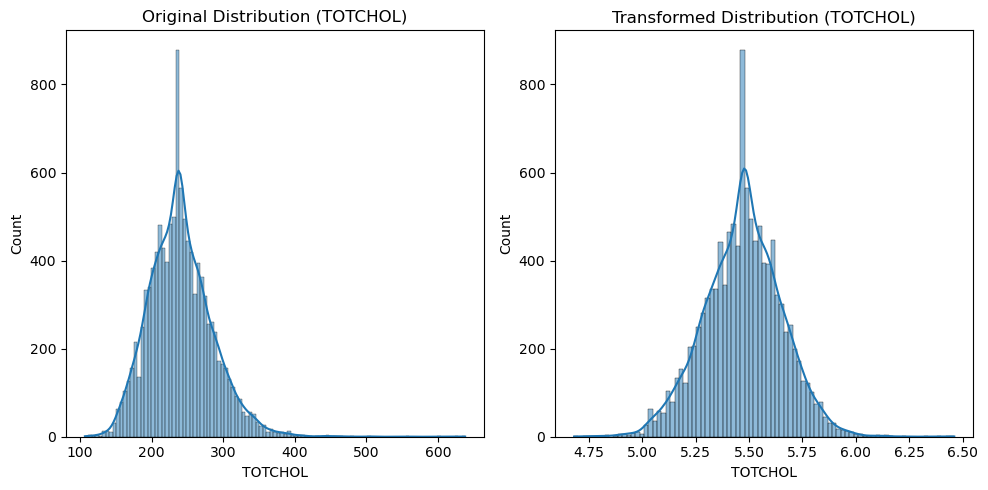

In [124]:
# Compute skewness of numerical features
skewness = data_filtered.select_dtypes(include=['float64', 'int64']).apply(lambda x: x.skew())

# Filter features with skewness above a certain threshold (e.g., 0.5)
skewed_features = skewness[skewness > 0.5]

# Print the skewed features and their skewness values
print("Skewed Features:")
print(skewed_features)

# Optionally, visualize the distribution of skewed features before and after transformation
import seaborn as sns
import matplotlib.pyplot as plt

# Example of visualizing the distribution of a skewed feature before and after transformation
feature_name = 'TOTCHOL'
plt.figure(figsize=(10, 5))

# Plot the original distribution
plt.subplot(1, 2, 1)
sns.histplot(data_filtered[feature_name], kde=True)
plt.title(f'Original Distribution ({feature_name})')

# Apply transformation (e.g., log transformation) to the feature
transformed_feature = np.log1p(data_filtered[feature_name])

# Plot the transformed distribution
plt.subplot(1, 2, 2)
sns.histplot(transformed_feature, kde=True)
plt.title(f'Transformed Distribution ({feature_name})')

plt.tight_layout()
plt.show()


In [ ]:
# Drop the 'RANDID' column from the filtered dataset
data_filtered = data_filtered.drop('RANDID', axis=1)

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report

# Separate features (X) and target variable (y)
X = data_filtered.drop('CVD', axis=1)
y = data_filtered['CVD']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the features (optional but recommended for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the KNN classifier
knn.fit(X_train_scaled, y_train)

# Predict the target variable for the test set
y_pred = knn.predict(X_test_scaled)

# Evaluate the performance of the KNN model
accuracy = accuracy_score(y_test, y_pred)
print("KNN Classifier Accuracy:", accuracy)

# Print classification report for KNN
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred))

KNN Classifier Accuracy: 0.9094138543516874

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1730
           1       0.87      0.71      0.79       522

    accuracy                           0.91      2252
   macro avg       0.89      0.84      0.86      2252
weighted avg       0.91      0.91      0.91      2252

